# Comparing Linear Bayesian Regressors
This example compares two bayesian regressors: ARD, BayesianRidge

## 1. Normal linear
linear data

### Generate synthetic dataset  


In [2]:
from sklearn.datasets import make_regression
X,y, true_weights = make_regression(
    n_samples=100,
    n_features=100,
    n_informative=10, # features generate y. Others unuseful coef = 0
    coef=True,
    random_state=42 ,# noise
    noise=8,
)

### Fit 

In [3]:
import pandas as pd
from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression
olr = LinearRegression().fit(X,y)
brr = BayesianRidge(compute_score=True, max_iter=30).fit(X,y) 
ard = ARDRegression(compute_score=True, max_iter=30).fit(X,y) # socre: liklihood
df = pd.DataFrame(
    {
        'weights of true generative process' : true_weights,
        'ARDRegression':ard.coef_,
        'BayesianRidge':brr.coef_,
        'LinearRegression':olr.coef_,
    }
)

,weights of true generative process,ARDRegression,BayesianRidge,LinearRegression
0,0.000000,-0.590226,-0.631933,2.360746
1,0.000000,-0.001504,-3.250621,-3.409375
2,0.000000,-0.000594,-2.509021,-2.580928
3,0.000000,-0.000171,2.541967,8.836650
4,32.125517,33.179873,34.489623,37.133735
...,...,...,...,...
95,0.000000,-0.000064,-6.270549,-11.378404
96,0.000000,0.000780,0.430155,0.292874
97,0.000000,-0.000342,1.065423,-0.389722
98,0.000000,0.001329,-0.771873,3.235766


### plot coefficients

Text(0.5, 1.0, "Model's coefficients")

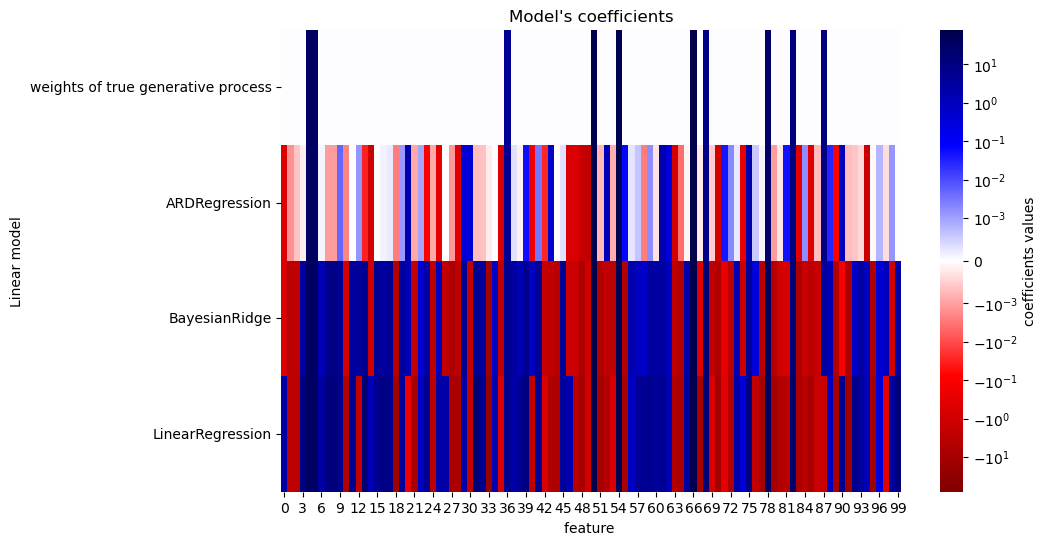

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import SymLogNorm # 对数化降低高低数据
plt.figure(figsize=(10,6))
sns.heatmap(
    df.T,
    norm = SymLogNorm(linthresh=10e-4, vmin=-80, vmax=80),
    cbar_kws={"label":"coefficients values"},
    cmap='seismic_r'
)
plt.ylabel('Linear model')
plt.xlabel('feature ')
plt.title("Model's coefficients")

Due to the noise ,none of the linear models can recover the true weights.
Compared the OLS estimator(LinearRegression): ARD get some sparse coef. BayesianRidge have slight changes.

### Plot the marginal log-likelihood
Plot bayesian max-likehihood with iterations.

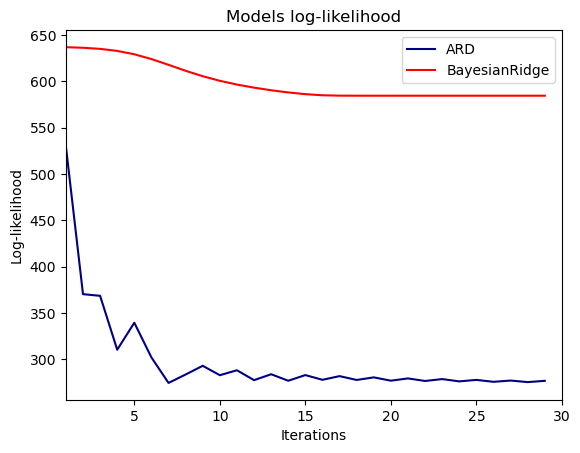

In [5]:
import numpy as np

ard_scores = -np.array(ard.scores_)
brr_scores = -np.array(brr.scores_)
plt.plot(ard_scores, color="navy", label="ARD")
plt.plot(brr_scores, color="red", label="BayesianRidge")
plt.ylabel("Log-likelihood")
plt.xlabel("Iterations")
plt.xlim(1, 30)
plt.legend()
_ = plt.title("Models log-likelihood")

## 2. PolynomialFeatures Expandsion.
Data is linear:
$$y = w_0 + w_1 x_1 + w_2 x_2 + \dots + w_n x_n + \epsilon$$
Data is't linear, we can expand it. Then we empose linear regression.
$$y = w_0 + w_1 x + w_2 x^2 + w_3 x^3 + \dots + w_n x^n + \epsilon$$

### Generate synthetic dataset
Now we create a non-linear function of the input feature.

In [63]:
from sklearn.preprocessing import PolynomialFeatures,StandardScaler

n_samples = 110
rng = np.random.RandomState(0)
X = np.sort(-10 * rng.rand(n_samples) + 10) # 0, 10
noise = rng.normal(0,1,n_samples)*1.35 # Suite 假设
y = np.sqrt(X) * np.sin(X) + noise
full_data = pd.DataFrame({
    'input_feature':X,
    'target':y
})
print(X.shape, y.shape)


(110,) (110,)


In [64]:
X = X.reshape((-1, 1)) # 转为列向量
X.shape

(110, 1)

In [65]:
X_plot = np.linspace(10, 10.4, 10) # test
y_plot = np.sqrt(X_plot)*np.sin(X_plot) # true without noise

X_plot = np.concatenate((X, X_plot.reshape((-1, 1))))# draw 
y_plot = np.concatenate((y - noise, y_plot)) # draw without noise

### FIT
`fit_intercept = True` is default in `ARD` and `BayesianRidge`, but `PolynomialFeatures` should't introduce bias.

`return_std = True` , bayesian regressors return the std. of posteiror distribution.

In [66]:
from sklearn.pipeline import make_pipeline
ard_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    ARDRegression()
).fit(X,y)

brr_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    BayesianRidge()
).fit(X,y)

y_ard, y_ard_std = ard_poly.predict(X_plot,return_std = True)
y_brr, y_brr_std = brr_poly.predict(X_plot,return_std = True)


### Plot polynomial regressions with std. errorbar

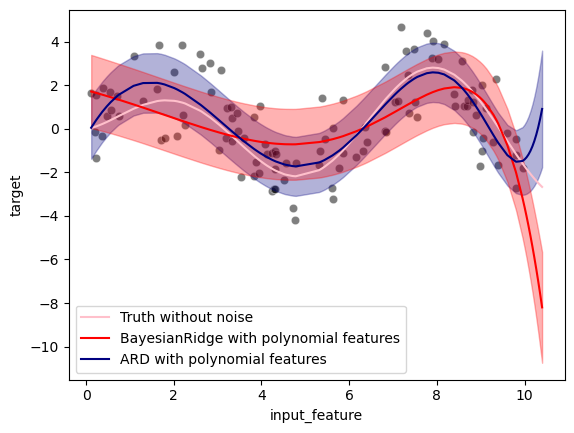

In [68]:
ax = sns.scatterplot(
    data=full_data, # real data with noise
    x='input_feature',
    y='target',
    color='black',
    alpha=0.5
)
ax.plot(X_plot,y_plot, color='pink', label ='Truth without noise')
ax.plot(X_plot, y_brr, color='red', label = 'BayesianRidge with polynomial features')
ax.plot(X_plot, y_ard, color='navy', label='ARD with polynomial features')
# error bar
ax.fill_between(
    X_plot.ravel(),
    y_ard-y_ard_std,
    y_ard+y_ard_std,
    alpha=0.3,
    color='navy'
)
ax.fill_between(
    X_plot.ravel(),
    y_brr-y_brr_std,
    y_brr+y_brr_std,
    alpha=0.3,
    color='red'
)
ax.legend()

📈
Due to the intrinsic limitations of a polynomial regression, models fail when extraploatin(for test data).